2602191301 - Allin Setiawan

**Twitter Sentiment Analisis**
* teknik yang digunakan untuk  memahami dan mengekstrak opini, persepsi dan emosi dari percakapan dalam twitter.
* Case: Melakukan Prediksi Text yang telah dipost/dikirimkan oleh user apakah termasuk kedalam categori: netral, positif dan negatif jika negatif maka dapat melakukan takedown agar tidak menjatuhkan nama/brand, dsbnya.

In [195]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU, Dropout
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, confusion_matrix

In [172]:
!unzip /content/sentiment_twitter.zip

Archive:  /content/sentiment_twitter.zip
replace twitter_training.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#Read Dataset

Sebelumnya dari dataset yang didapatkan sudah terbagi dengan dataset training dan dataset testnya.

In [173]:
df_train = pd.read_csv('twitter_training.csv')
df_train.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [174]:
df_test = pd.read_csv('twitter_validation.csv')
df_test.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


# Preprocessing Data

In [175]:
df_train.columns

Index(['2401', 'Borderlands', 'Positive',
       'im getting on borderlands and i will murder you all ,'],
      dtype='object')

In [176]:
df_test.columns

Index(['3364', 'Facebook', 'Irrelevant',
       'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣'],
      dtype='object')

In [177]:
df_train.columns = ['Tweet ID', 'Entity', 'Sentiment', 'Tweet Content']
df_test.columns = ['Tweet ID', 'Entity', 'Sentiment', 'Tweet Content']

# Drop unnecessary columns
df_train.drop(columns=['Tweet ID', 'Entity'], inplace=True)
df_test.drop(columns=['Tweet ID', 'Entity'], inplace=True)

In [178]:
df_train.isna().sum()

Sentiment          0
Tweet Content    686
dtype: int64

In [179]:
df_test.isna().sum()

Sentiment        0
Tweet Content    0
dtype: int64

In [180]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [181]:
df_train.duplicated().sum()
df_test.duplicated().sum()

1

In [182]:
df_train.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)

In [183]:
twitter_sentiments = pd.concat([df_train,df_test],ignore_index=True)
twitter_sentiments.shape
twitter_sentiments.duplicated().sum()

515

In [184]:
twitter_sentiments['Tweet Content Length'] = twitter_sentiments['Tweet Content'].apply(len)
twitter_sentiments.head()
twitter_sentiments.iloc[:10]

,Sentiment,Tweet Content,Tweet Content Length
0,Positive,I am coming to the borders and I will kill you...,51
1,Positive,im getting on borderlands and i will kill you ...,50
2,Positive,im coming on borderlands and i will murder you...,51
3,Positive,im getting on borderlands 2 and i will murder ...,57
4,Positive,im getting into borderlands and i can murder y...,53
5,Positive,So I spent a few hours making something for fu...,286
6,Positive,So I spent a couple of hours doing something f...,293
7,Positive,So I spent a few hours doing something for fun...,139
8,Positive,So I spent a few hours making something for fu...,283
9,Positive,2010 So I spent a few hours making something f...,288


In [185]:
print(f"Sentiment value count: \n {twitter_sentiments['Sentiment'].value_counts()}")

Sentiment value count: 
 Sentiment
Negative      21503
Positive      19413
Neutral       17395
Irrelevant    12455
Name: count, dtype: int64


In [186]:
twitter_sentiments['Sentiment'] = twitter_sentiments['Sentiment'].apply(lambda x: 'Neutral' if x.lower() in ['neutral', 'irrelevant'] else x)
print(f"Sentiment value count: \n {twitter_sentiments['Sentiment'].value_counts()}")

Sentiment value count: 
 Sentiment
Neutral     29850
Negative    21503
Positive    19413
Name: count, dtype: int64


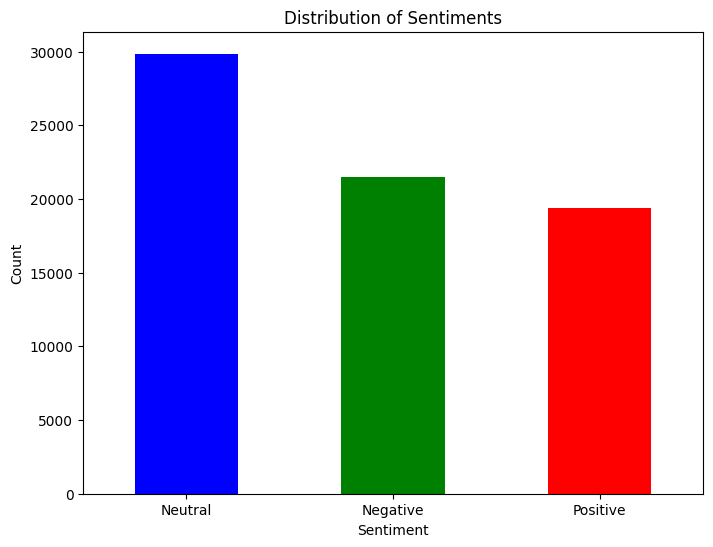

In [187]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'twitter_sentiments' is your DataFrame
sentiments_count = twitter_sentiments['Sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sentiments_count.plot(kind='bar', color=['blue', 'green', 'red'])
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

In [188]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

#Proses membersihkan text dengan menghilangkan emoji, special charac dsbnya
def clean_text(text: str) -> str:
    text = text.lower()
    text = remove_special_characters_and_emojis(text)
    text = remove_urls(text)
    text = remove_mentions_and_hashtags(text)
    text = remove_html_tags(text)
    text = expand_contractions(text)
    text = remove_punctuation(text)
    text = remove_extra_whitespaces(text)
    text = tokenize_and_lemmatize(text)
    return text
def remove_urls(text: str) -> str:
    return re.sub(r'https*\S+', ' ', text)

def remove_mentions_and_hashtags(text: str) -> str:
    return re.sub(r'[@#]\S+', ' ', text)

def remove_html_tags(text: str) -> str:
    return re.sub('<.*?>', '', text)

def expand_contractions(text: str) -> str:
    contractions = {"don't": 'do not', "can't": 'cannot'}
    for contraction, expanded in contractions.items():
        text = text.replace(contraction, expanded)
    return text

def remove_punctuation(text: str) -> str:
    return re.sub('[%s]' % re.escape(string.punctuation), '', text)
def remove_extra_whitespaces(text: str) -> str:
    return re.sub('\s{2,}', ' ', text)

def remove_special_characters_and_emojis(text: str) -> str:
    special_char_pattern = r'[^a-zA-Z0-9\s]|[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]'

    return re.sub(special_char_pattern, '', text)

def tokenize_and_lemmatize(text: str) -> str:
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    stopwords_set = set(stopwords.words('english'))
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords_set]
    return ' '.join(lemmatized_words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [189]:
df_train['cleaned_tweet'] = df_train['Tweet Content'].apply(clean_text)
df_test['cleaned_tweet'] = df_test['Tweet Content'].apply(clean_text)

In [190]:
df_train['Sentiment'] = df_train['Sentiment'].apply(lambda x: 'Neutral' if x.lower() in ['neutral', 'irrelevant'] else x)
print(f"Sentiment value count: \n {df_train['Sentiment'].value_counts()}")

Sentiment value count: 
 Sentiment
Neutral     29394
Negative    21237
Positive    19137
Name: count, dtype: int64


In [191]:
df_test['Sentiment'] = df_test['Sentiment'].apply(lambda x: 'Neutral' if x.lower() in ['neutral', 'irrelevant'] else x)
print(f"Sentiment value count: \n {df_test['Sentiment'].value_counts()}")

Sentiment value count: 
 Sentiment
Neutral     456
Positive    276
Negative    266
Name: count, dtype: int64


In [196]:
label_encoder = LabelEncoder()
df_train['encoded_sentiment'] = label_encoder.fit_transform(df_train['Sentiment'])
df_test['encoded_sentiment'] = label_encoder.transform(df_test['Sentiment'])

In [197]:
# Combine text from both datasets for Word2Vec training
twitter_sentiments = pd.concat([df_train['cleaned_tweet'], df_test['cleaned_tweet']])

# Tokenize tweets for Word2Vec
tokenized_tweets = [tweet.split() for tweet in twitter_sentiments]

# Train Word2Vec model
w2v_model = Word2Vec(tokenized_tweets, vector_size=100, window=5, min_count=1, sample=1e-3, epochs=10)

In [199]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(twitter_sentiments)

# Convert tweets to sequences
train_sequences = tokenizer.texts_to_sequences(df_train['cleaned_tweet'])
test_sequences = tokenizer.texts_to_sequences(df_test['cleaned_tweet'])

# Pad sequences
X_train = pad_sequences(train_sequences, maxlen=100)
X_test = pad_sequences(test_sequences, maxlen=100)

# Prepare labels
y_train = df_train['encoded_sentiment']
y_test = df_test['encoded_sentiment']

# LSTM MODEL

LSTM adalah jenis RNN yang biasanya digunakan untuk sentiment analisis, LSTM mampu menganalisis teks untuk memahami opini dan emosi yang dapat diperhatikan dari urutan kata dan seluruh konteks kalimatnya.

In [200]:
label_dict = {0: "Negative", 1: "Neutral", 2: "Positive"}

In [201]:
def accuracy_per_class(preds, y_test, label_dict):
    y_pred = np.argmax(preds, axis=1)
    for label in np.unique(y_test):
        idx = (y_test == label)
        accuracy = (y_pred[idx] == y_test[idx]).mean()
        print(f"Accuracy for class {label_dict.get(label, label)}: {accuracy:.4f}")

In [202]:
def plot_confusion_matrix(model, X_test, y_test):
    # Make predictions
    preds = model.predict(X_test)

    # Convert probabilities to class labels (if needed)
    if len(preds.shape) > 1 and preds.shape[1] > 1:
        preds_classes = np.argmax(preds, axis=1)
    else:
        preds_classes = preds

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, preds_classes)

    # Plot confusion matrix using Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['1', '2', '3'], yticklabels=['1', '2', '3'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [203]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(model, X_test, y_test):
    y_probs = model.predict(X_test)
    plt.figure(figsize=(8, 6))
    n_classes = y_probs.shape[1]
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test == i, y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

In [204]:
model = Sequential()
model.add(Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 100))
model.add(LSTM(128))
model.add(Dense(3, activation='softmax'))

In [205]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [206]:
model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
1745/1745 [==============================] - 36s 19ms/step - loss: 0.5920 - accuracy: 0.7470 - val_loss: 1.2847 - val_accuracy: 0.5288
Epoch 2/10
1745/1745 [==============================] - 15s 8ms/step - loss: 0.2223 - accuracy: 0.9164 - val_loss: 1.7123 - val_accuracy: 0.5232
Epoch 3/10
1745/1745 [==============================] - 15s 8ms/step - loss: 0.1351 - accuracy: 0.9488 - val_loss: 2.1888 - val_accuracy: 0.4983
Epoch 4/10
1745/1745 [==============================] - 14s 8ms/step - loss: 0.0989 - accuracy: 0.9618 - val_loss: 2.2941 - val_accuracy: 0.5022
Epoch 5/10
1745/1745 [==============================] - 15s 8ms/step - loss: 0.0798 - accuracy: 0.9687 - val_loss: 2.6030 - val_accuracy: 0.5158
Epoch 6/10
1745/1745 [==============================] - 14s 8ms/step - loss: 0.0666 - accuracy: 0.9744 - val_loss: 2.6991 - val_accuracy: 0.4993
Epoch 7/10
1745/1745 [==============================] - 14s 8ms/step - loss: 0.0565 - accuracy: 0.9775 - val_loss: 3.0042 - val_a

In [207]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

32/32 [==============================] - 0s 4ms/step - loss: 0.8924 - accuracy: 0.8617
Test Loss: 0.8923883438110352
Test Accuracy: 0.8617234230041504


In [208]:
preds = model.predict(X_test)

32/32 [==============================] - 0s 3ms/step


In [209]:
accuracy_per_class(preds, y_test.values, label_dict)

Accuracy for class Negative: 0.8459
Accuracy for class Neutral: 0.8618
Accuracy for class Positive: 0.8768


In [210]:
preds_classes = np.argmax(preds, axis=1)

In [211]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, preds_classes, target_names=['0','1','2']))


Classification Report

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       266
           1       0.89      0.86      0.87       456
           2       0.83      0.88      0.86       276

    accuracy                           0.86       998
   macro avg       0.86      0.86      0.86       998
weighted avg       0.86      0.86      0.86       998



32/32 [==============================] - 0s 3ms/step


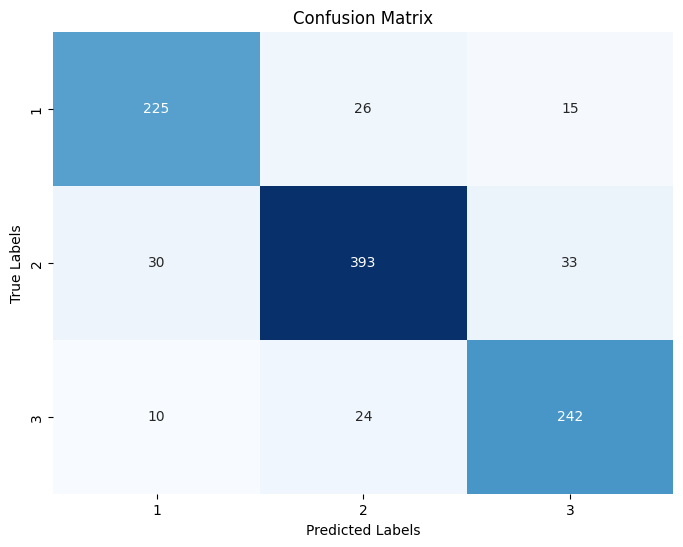

In [212]:
plot_confusion_matrix(model, X_test, y_test)

Dari hasil confusion matrix diatas model dapat dikatakan baik karena memiliki nilai yang cukup tinggi dalam mempredict, dapat dilihat bahwa predicted labels dengan true labels kebanyakan benar namun memang ada beberapa hasil predict yang tidak sesuai dengan true labelsnya.

32/32 [==============================] - 0s 3ms/step


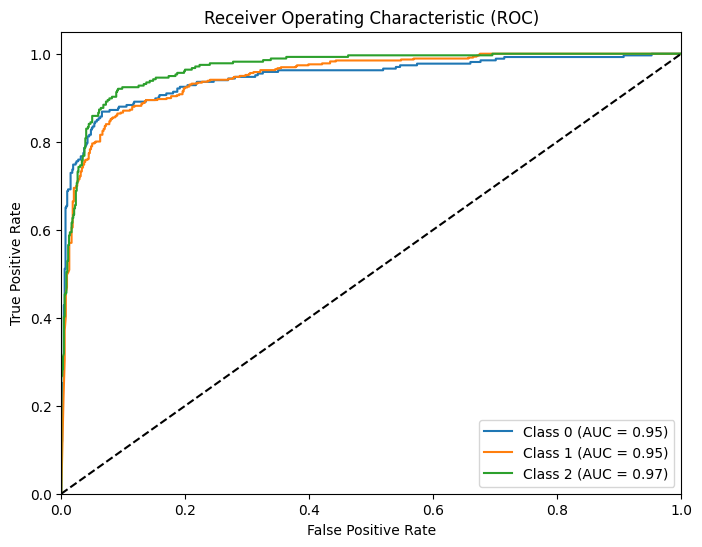

In [213]:
plot_roc_auc(model, X_test, y_test)

ROC dan AUC merupakan metrik evaluasi yang cukup informatif dan penting dalam sentiment analisis. Nilai ROC dan AUC yang tinggi dapat menunjukkan bahwa model dapat memprediksi dengan baik dan akurat. Dari hasil ROC dan AUC di atas dapat dikatakan bahwa model baik karena nilai AUC masing-masing kelas mendekati 1.

# GRU MODEL

GRU adalah jenis RNN yang biasanya digunakan untuk sentiment analisis, GRU mampu menganalisis teks untuk memahami opini dan emosi yang dapat diperhatikan dari urutan kata dan seluruh konteks kalimatnya. GRU lebih cepat untuk dilatih dibandingkan LSTM.

In [214]:
model2 = Sequential()
model2.add(Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 100))
model2.add(GRU(128))  # GRU layer with 128 units
model2.add(Dense(3, activation='softmax'))

In [215]:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [216]:
model2.fit(X_train, y_train, epochs=10, validation_split=0.2) # Use validation_split for a 20% split

Epoch 1/10
1745/1745 [==============================] - 34s 18ms/step - loss: 0.5707 - accuracy: 0.7553 - val_loss: 1.3386 - val_accuracy: 0.5455
Epoch 2/10
1745/1745 [==============================] - 15s 8ms/step - loss: 0.2013 - accuracy: 0.9252 - val_loss: 1.7075 - val_accuracy: 0.5213
Epoch 3/10
1745/1745 [==============================] - 14s 8ms/step - loss: 0.1230 - accuracy: 0.9536 - val_loss: 1.9534 - val_accuracy: 0.5145
Epoch 4/10
1745/1745 [==============================] - 14s 8ms/step - loss: 0.0942 - accuracy: 0.9644 - val_loss: 2.0337 - val_accuracy: 0.5077
Epoch 5/10
1745/1745 [==============================] - 14s 8ms/step - loss: 0.0711 - accuracy: 0.9723 - val_loss: 2.4059 - val_accuracy: 0.5017
Epoch 6/10
1745/1745 [==============================] - 13s 8ms/step - loss: 0.0586 - accuracy: 0.9773 - val_loss: 2.5416 - val_accuracy: 0.4982
Epoch 7/10
1745/1745 [==============================] - 13s 7ms/step - loss: 0.0505 - accuracy: 0.9799 - val_loss: 3.0147 - val_a

In [217]:
loss, accuracy = model2.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

32/32 [==============================] - 0s 3ms/step - loss: 0.7755 - accuracy: 0.8677
Test Loss: 0.7754607200622559
Test Accuracy: 0.8677354454994202


In [218]:
preds_model2 = model2.predict(X_test)

32/32 [==============================] - 0s 3ms/step


In [219]:
accuracy_per_class(preds_model2, y_test.values, label_dict)

Accuracy for class Negative: 0.8609
Accuracy for class Neutral: 0.8750
Accuracy for class Positive: 0.8623


In [220]:
preds_classesModel2 = np.argmax(preds_model2, axis=1)

In [224]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, preds_classesModel2, target_names=['0','1','2']))


Classification Report

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       266
           1       0.89      0.88      0.88       456
           2       0.85      0.86      0.86       276

    accuracy                           0.87       998
   macro avg       0.86      0.87      0.86       998
weighted avg       0.87      0.87      0.87       998



Dari hasil model GRU diatas dapat dikatakan bahwa model yang dilatih cukup baik dengan nilai akurasi 0.87 ,nilai f1-score 0.86, nilai recall 0.87, nilai precision 0.86

32/32 [==============================] - 0s 3ms/step


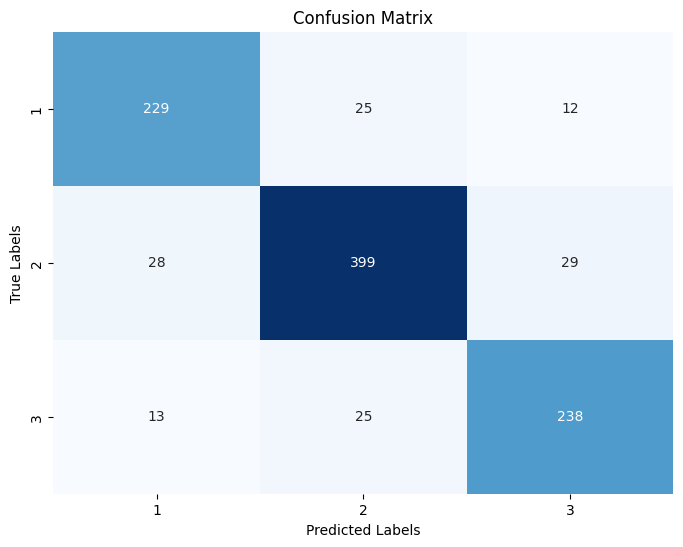

In [222]:
plot_confusion_matrix(model2, X_test, y_test)

Hasil Confusion Matrix GRU ini tidak beda jauh dengan LSTM namun jika dibandingkan nilai predict yang tidak sesuai dengan true labels lebih kecil dibandingkan LSTM.

32/32 [==============================] - 0s 4ms/step


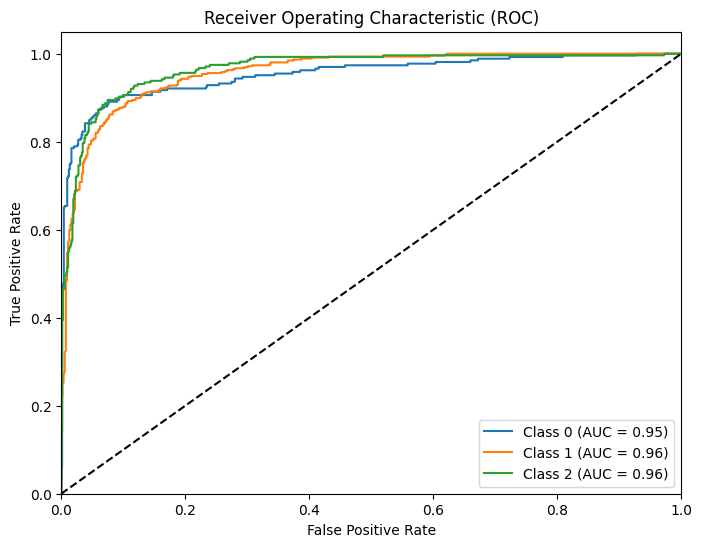

In [223]:
plot_roc_auc(model2, X_test, y_test)

ROC dan AUC merupakan metrik evaluasi yang cukup informatif dan penting dalam sentiment analisis. Nilai ROC dan AUC yang tinggi dapat menunjukkan bahwa model dapat memprediksi dengan baik dan akurat. Dari hasil ROC dan AUC di atas dapat dikatakan bahwa model baik karena nilai AUC masing-masing kelas mendekati 1.

# Evaluate and Future Direction
Dari hasil 2 model diatas yaitu LSTM dan GRU. Saya dapat mengambil kesimpulan bahwa kedua model baik untuk sentiment analisis di case ini namun GRU memiliki hasil yang lebih baik dari nilai accuracy yang hanya beda 0.01 dengan nilai GRU 0.87 dan LSTM 0.86 namun tidak hanya accuracy saja yang menjadi penentuan bahwa model tersebut baik tapi dari hasil Recall, Precision dan F1-Score GRU memiliki hasil yang better dibanding LSTM mungkin hal ini disebabkan karena GRU lebih cepat dilatih dibanding LSTM karena LSTM cukup kompleks. Menurut saya dalam kasus ini GRU lebih baik dibanding LSTM karena nilai akurasi yang lebih baik dan lebih cepat juga. Untuk Kedepannya model ini dapat menambahkan layer pada model yang ingin dibuat karena model yang saya buat layernya sedikit.